# Importing Dataset from Google Drive

In [18]:
!pip install gdown
import gdown
import os
from zipfile import ZipFile
from IPython.display import display, HTML


# Extract the file ID from the Google Drive link
GOOGLE_DRIVE_FILE_ID = '1YOdAkuWBLzSDgatUjJHreGryq9a0HKqw'

# Define the download URL using the Google Drive file ID
download_url = f'https://drive.google.com/uc?id={GOOGLE_DRIVE_FILE_ID}'

# Define the output file name
output_file = 'archive.zip'

# Download the file
gdown.download(download_url, output_file, quiet=False)

# Create a destination folder
destination_folder = 'dataset'
os.makedirs(destination_folder, exist_ok=True)

# Extract the downloaded file
with ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f'Downloaded and extracted to {destination_folder}')


Downloading...
From: https://drive.google.com/uc?id=1YOdAkuWBLzSDgatUjJHreGryq9a0HKqw
To: /content/archive.zip
100%|██████████| 16.0M/16.0M [00:00<00:00, 91.3MB/s]


Downloaded and extracted to dataset


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sb
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [20]:
data_path = 'dataset/data.csv'
data = pd.read_csv(data_path)
print(data.head())

# Display basic statistics
print("Basic statistics of the dataset:")
print(data.describe())

print("\nData types and missing values:")
print(data.info())

# Count real and fake images
real_count = data[data['label'] == 'real'].shape[0]
fake_count = data[data['label'] == 'fake'].shape[0]

print(f"\nNumber of real images: {real_count}")
print(f"Number of fake images: {fake_count}")

  images_id label
0    real_1  real
1   real_10  real
2  real_100  real
3  real_101  real
4  real_102  real
Basic statistics of the dataset:
       images_id label
count       1289  1289
unique      1289     2
top       real_1  fake
freq           1   700

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   images_id  1289 non-null   object
 1   label      1289 non-null   object
dtypes: object(2)
memory usage: 20.3+ KB
None

Number of real images: 589
Number of fake images: 700


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preparation

In [22]:
height, width=128, 128
X=np.empty((data.shape[0], height, width, 3))
for i in range(data.shape[0]):
    img=load_img(r"dataset/{}/{}.jpg".format(data.loc[i, 'label'], \
                  data.loc[i, 'images_id']), target_size=(height, width))
    X[i]=img_to_array(img)
X.shape

(1289, 128, 128, 3)

In [23]:
def changeLabels(x):
    return labels[x]

labels=data.label.unique()
labels={labels[i]:i for i in range(labels.size)}
y=data.label.apply(changeLabels)
y[:5]

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [24]:
y=to_categorical(y, len(labels))
y=y.astype(int)
y[:5]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

**Split the dataset**

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=8)
X_train.shape, y_train.shape

# Display the counts
print(f"\nNumber of training images: {len(X_train)}")
print(f"Number of test images: {len(X_test)}")



Number of training images: 1031
Number of test images: 258


**Statistics About Dataset**

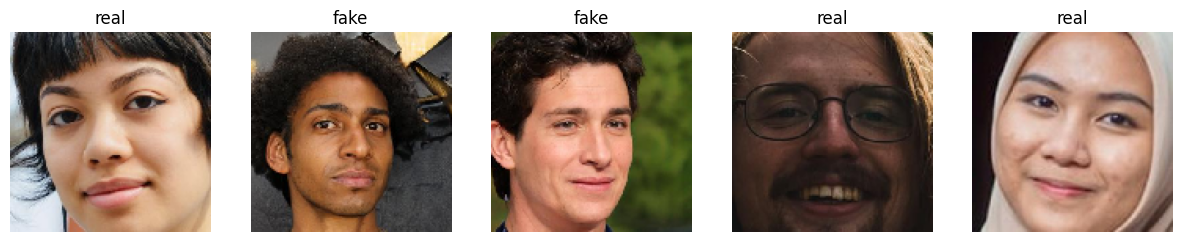

In [26]:
import matplotlib.pyplot as plt
import random


display(HTML(f"<h3 style='color:yellow; font-weight:bold;'>Few Random Images from Dataset </h3><br>"))
# Define a function to plot random images
def plot_random_images(data, X, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        index = random.randint(0, data.shape[0] - 1)
        img = X[index].astype('uint8')
        label = data.iloc[index]['label']
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Plot random images from the dataset
plot_random_images(data, X)



In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random

**Data Augementation**

In [28]:
# Create an ImageDataGenerator object for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

# CNN Model

**Define the model**

In [29]:
model = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(height, width, 3)),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.45),
    Dense(len(labels), activation='softmax')
])

**Early Stopping**

In [30]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

**Model Compile**

In [31]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

**Structure of the model**

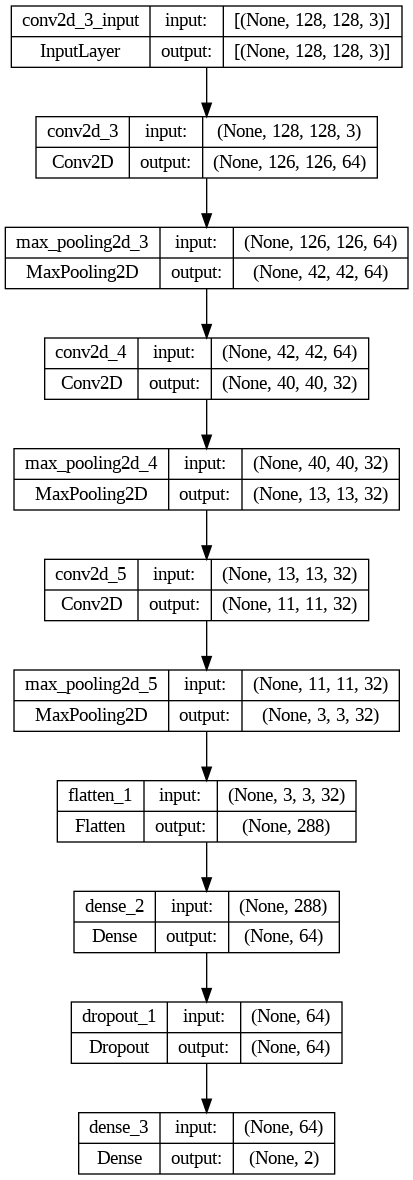

In [32]:
import matplotlib.pyplot as plt
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from tensorflow.keras.utils import plot_model


# def draw_neural_net(model, figsize=(12, 12)):
#     G = nx.DiGraph()
#     pos = {}
#     node_id = 0
#     layer_sizes = []

#     # Define positions and layers
#     for i, layer in enumerate(model.layers):
#         if isinstance(layer, Conv2D):
#             layer_sizes.append((layer.output_shape[-1], f"Conv2D\n{layer.output_shape}"))
#         elif isinstance(layer, MaxPooling2D):
#             layer_sizes.append((layer.output_shape[-1], f"MaxPooling2D\n{layer.output_shape}"))
#         elif isinstance(layer, Flatten):
#             layer_sizes.append((np.prod(layer.input_shape[1:]), f"Flatten\n{layer.output_shape}"))
#         elif isinstance(layer, Dense):
#             layer_sizes.append((layer.units, f"Dense\n{layer.output_shape}"))
#         elif isinstance(layer, Dropout):
#             layer_sizes.append((1, f"Dropout\n{layer.rate}"))

#     v_spacing = 10
#     h_spacing = 5

#     for i, (layer_size, layer_label) in enumerate(layer_sizes):
#         layer_top = v_spacing * (layer_size - 1) / 2.0
#         for j in range(layer_size):
#             G.add_node(node_id, pos=(i * h_spacing, layer_top - j * v_spacing), label=layer_label)
#             node_id += 1

#     for i in range(len(layer_sizes) - 1):
#         nodes_a = [n for n in G.nodes if G.nodes[n]['pos'][0] == i * h_spacing]
#         nodes_b = [n for n in G.nodes if G.nodes[n]['pos'][0] == (i + 1) * h_spacing]

#         for n_a in nodes_a:
#             for n_b in nodes_b:
#                 G.add_edge(n_a, n_b)

#     pos = nx.get_node_attributes(G, 'pos')
#     labels = nx.get_node_attributes(G, 'label')

#     plt.figure(figsize=figsize)
#     nx.draw(G, pos, labels=labels, with_labels=True, node_color='skyblue', node_size=2000, font_size=8, font_weight='bold', arrows=True)
#     plt.title("Neural Network Structure")
#     plt.show()

# # Draw the neural network with a specified figure size
# draw_neural_net(model, figsize=(6,3))

# Plot the model architecture
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)


**Model Train**

In [33]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Display the model summary
display(HTML(f"<h4 style='color:yellow; font-weight:bold;'>Model summary </h4><br>"))
model.summary()

# Assign the count of epochs to a new variable `epochs`
epochs = len(history.history['accuracy'])

# Display the epoch count
display(HTML(f"<h3 style='color:yellow; font-weight:bold;'>EarlyStopping epoch count: {epochs} epochs </h3><br>"))

Epoch 1/50
33/33 [==============================] - 56s 2s/step - loss: 0.6907 - accuracy: 0.5393 - val_loss: 0.6917 - val_accuracy: 0.4806
Epoch 2/50
33/33 [==============================] - 30s 898ms/step - loss: 0.6766 - accuracy: 0.5771 - val_loss: 0.6955 - val_accuracy: 0.4690
Epoch 3/50
33/33 [==============================] - 30s 904ms/step - loss: 0.6686 - accuracy: 0.5858 - val_loss: 0.6716 - val_accuracy: 0.5659
Epoch 4/50
33/33 [==============================] - 32s 964ms/step - loss: 0.6348 - accuracy: 0.6334 - val_loss: 0.6005 - val_accuracy: 0.6202
Epoch 5/50
33/33 [==============================] - 29s 888ms/step - loss: 0.5908 - accuracy: 0.6712 - val_loss: 0.6721 - val_accuracy: 0.5349
Epoch 6/50
33/33 [==============================] - 30s 897ms/step - loss: 0.6466 - accuracy: 0.6217 - val_loss: 0.5331 - val_accuracy: 0.6938
Epoch 7/50
33/33 [==============================] - 30s 898ms/step - loss: 0.5420 - accuracy: 0.7177 - val_loss: 0.4657 - val_accuracy: 0.8488
Ep

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 42, 42, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 32)         

# Output Evaluations

9/9 [==============================] - 2s 174ms/step


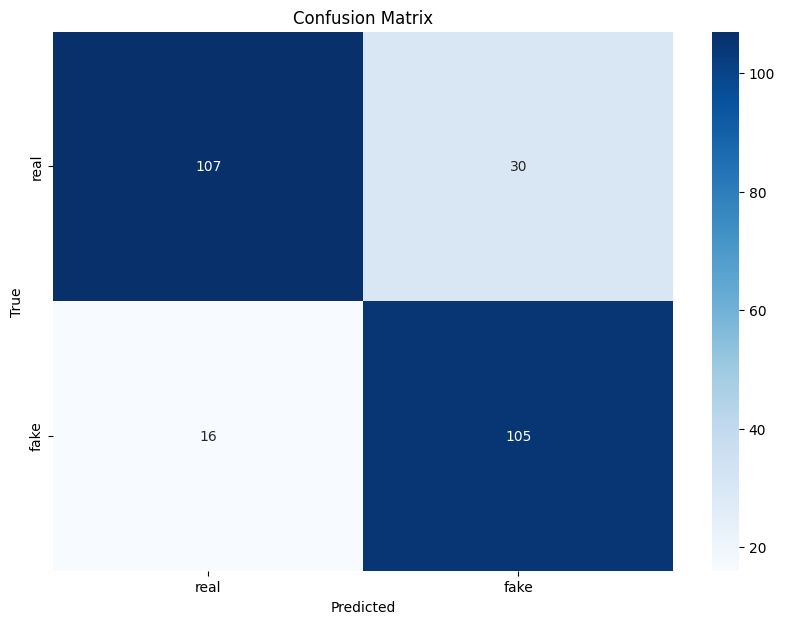

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Compute accuracy, precision, recall, and f1 score
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')



display(HTML(f"<h3 style='color:yellow; font-weight:bold;'>Evaluation after {epochs} epochs </h3><br>"))

# Create a DataFrame to display the metrics
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
}

metrics_df = pd.DataFrame(metrics)



def display_metrics(df):
    html = df.to_html(index=False)
    styled_html = html.replace('<td>', '<td style="font-weight: bold; color: red;">')
    display(HTML(styled_html))

# Display the DataFrame with custom styles
display_metrics(metrics_df)

display(HTML(f"<h3 style='color:Green; font-weight:bold;'>Confusion Matrix </h3><br>"))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Misclassified Images**

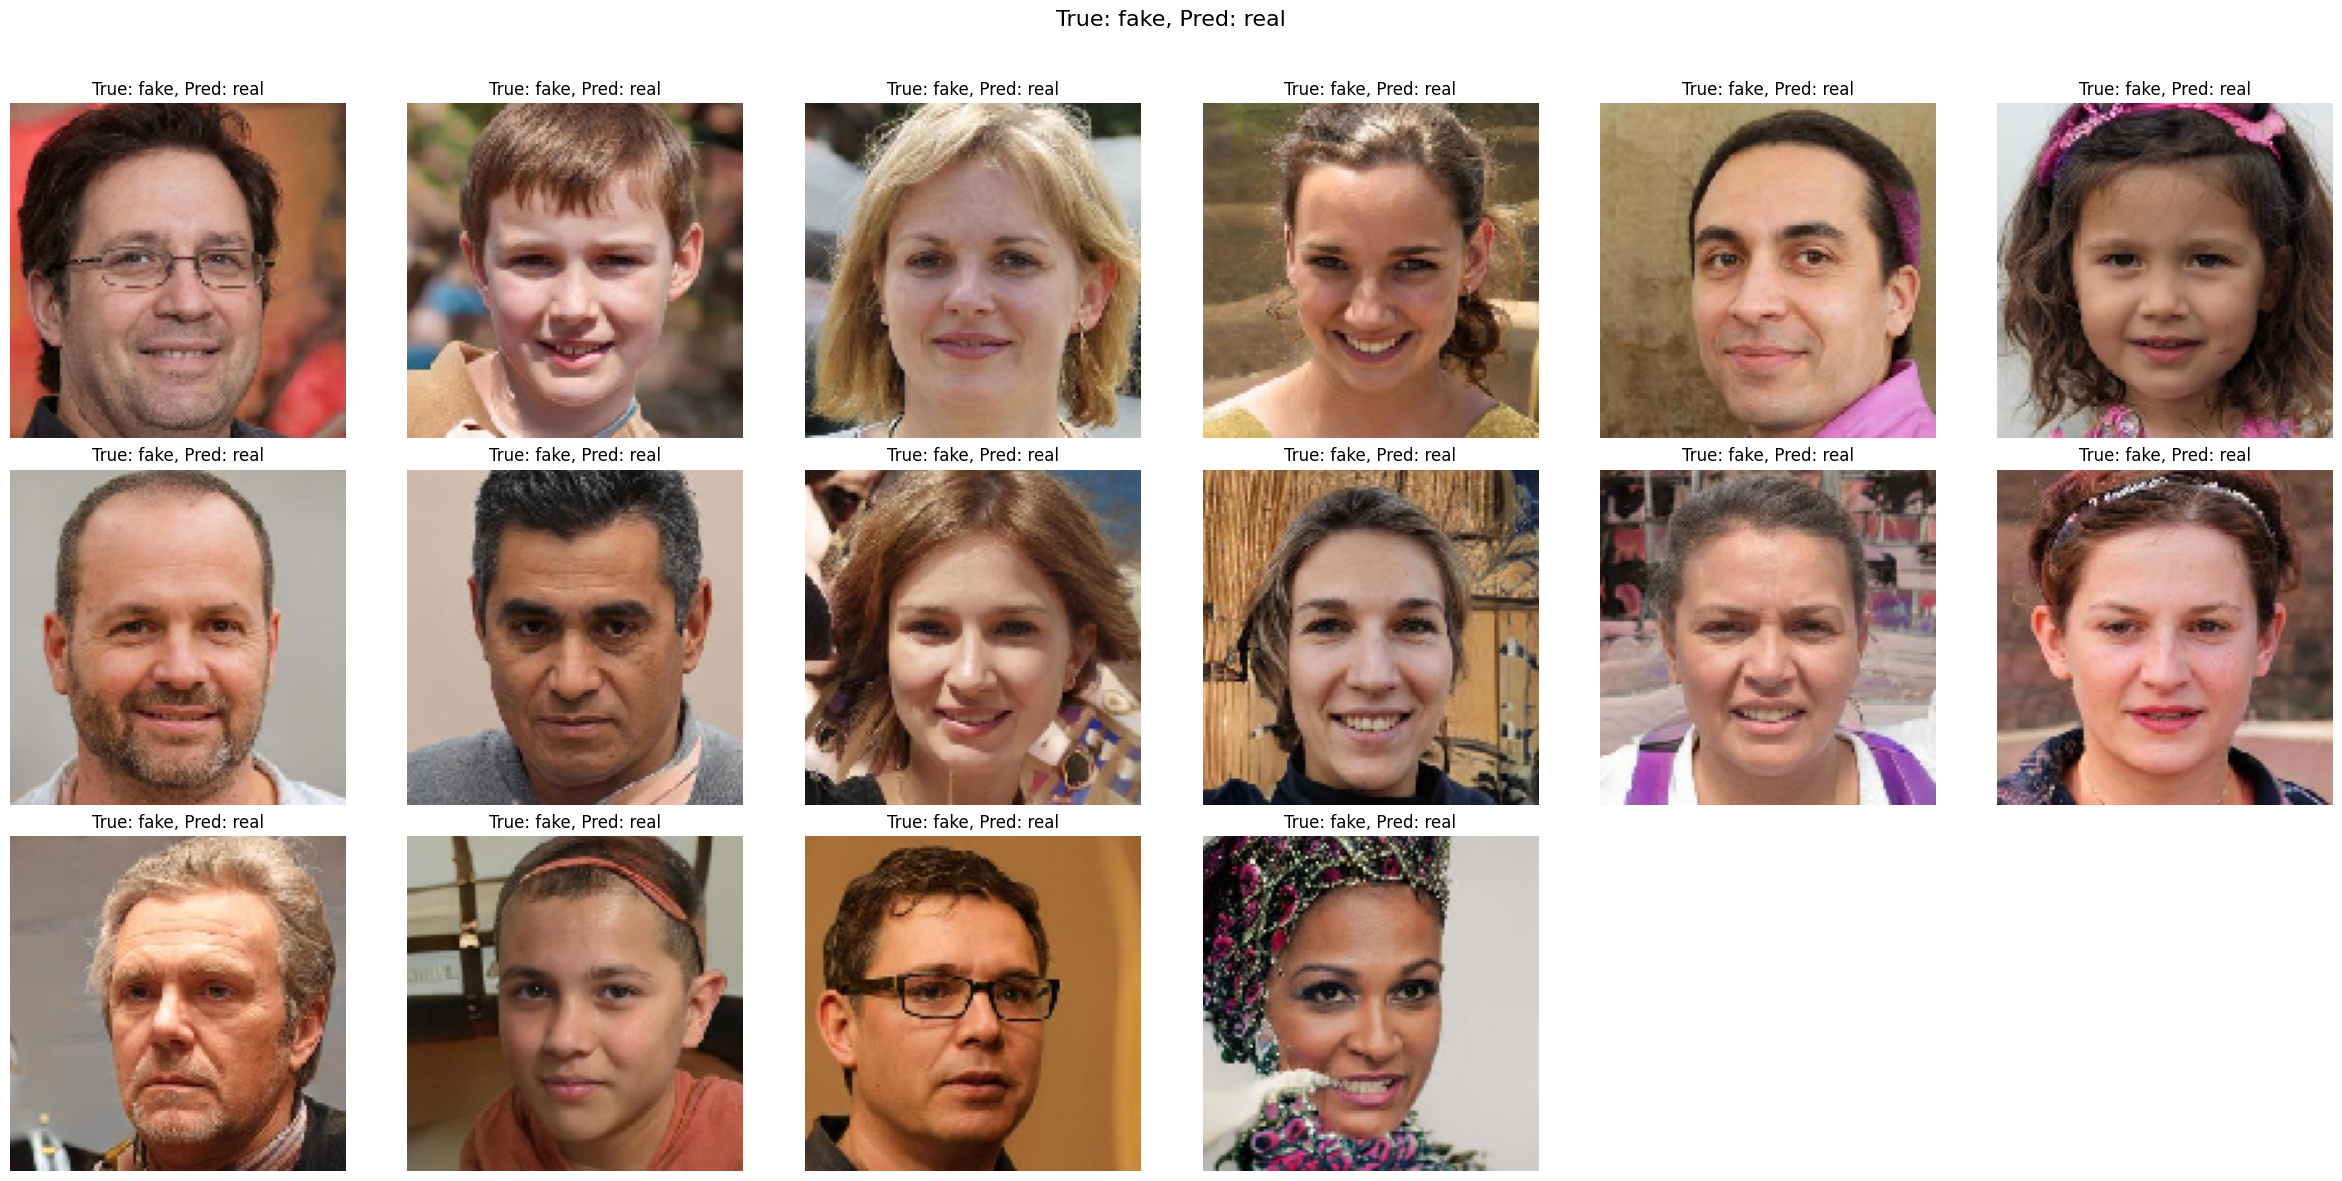

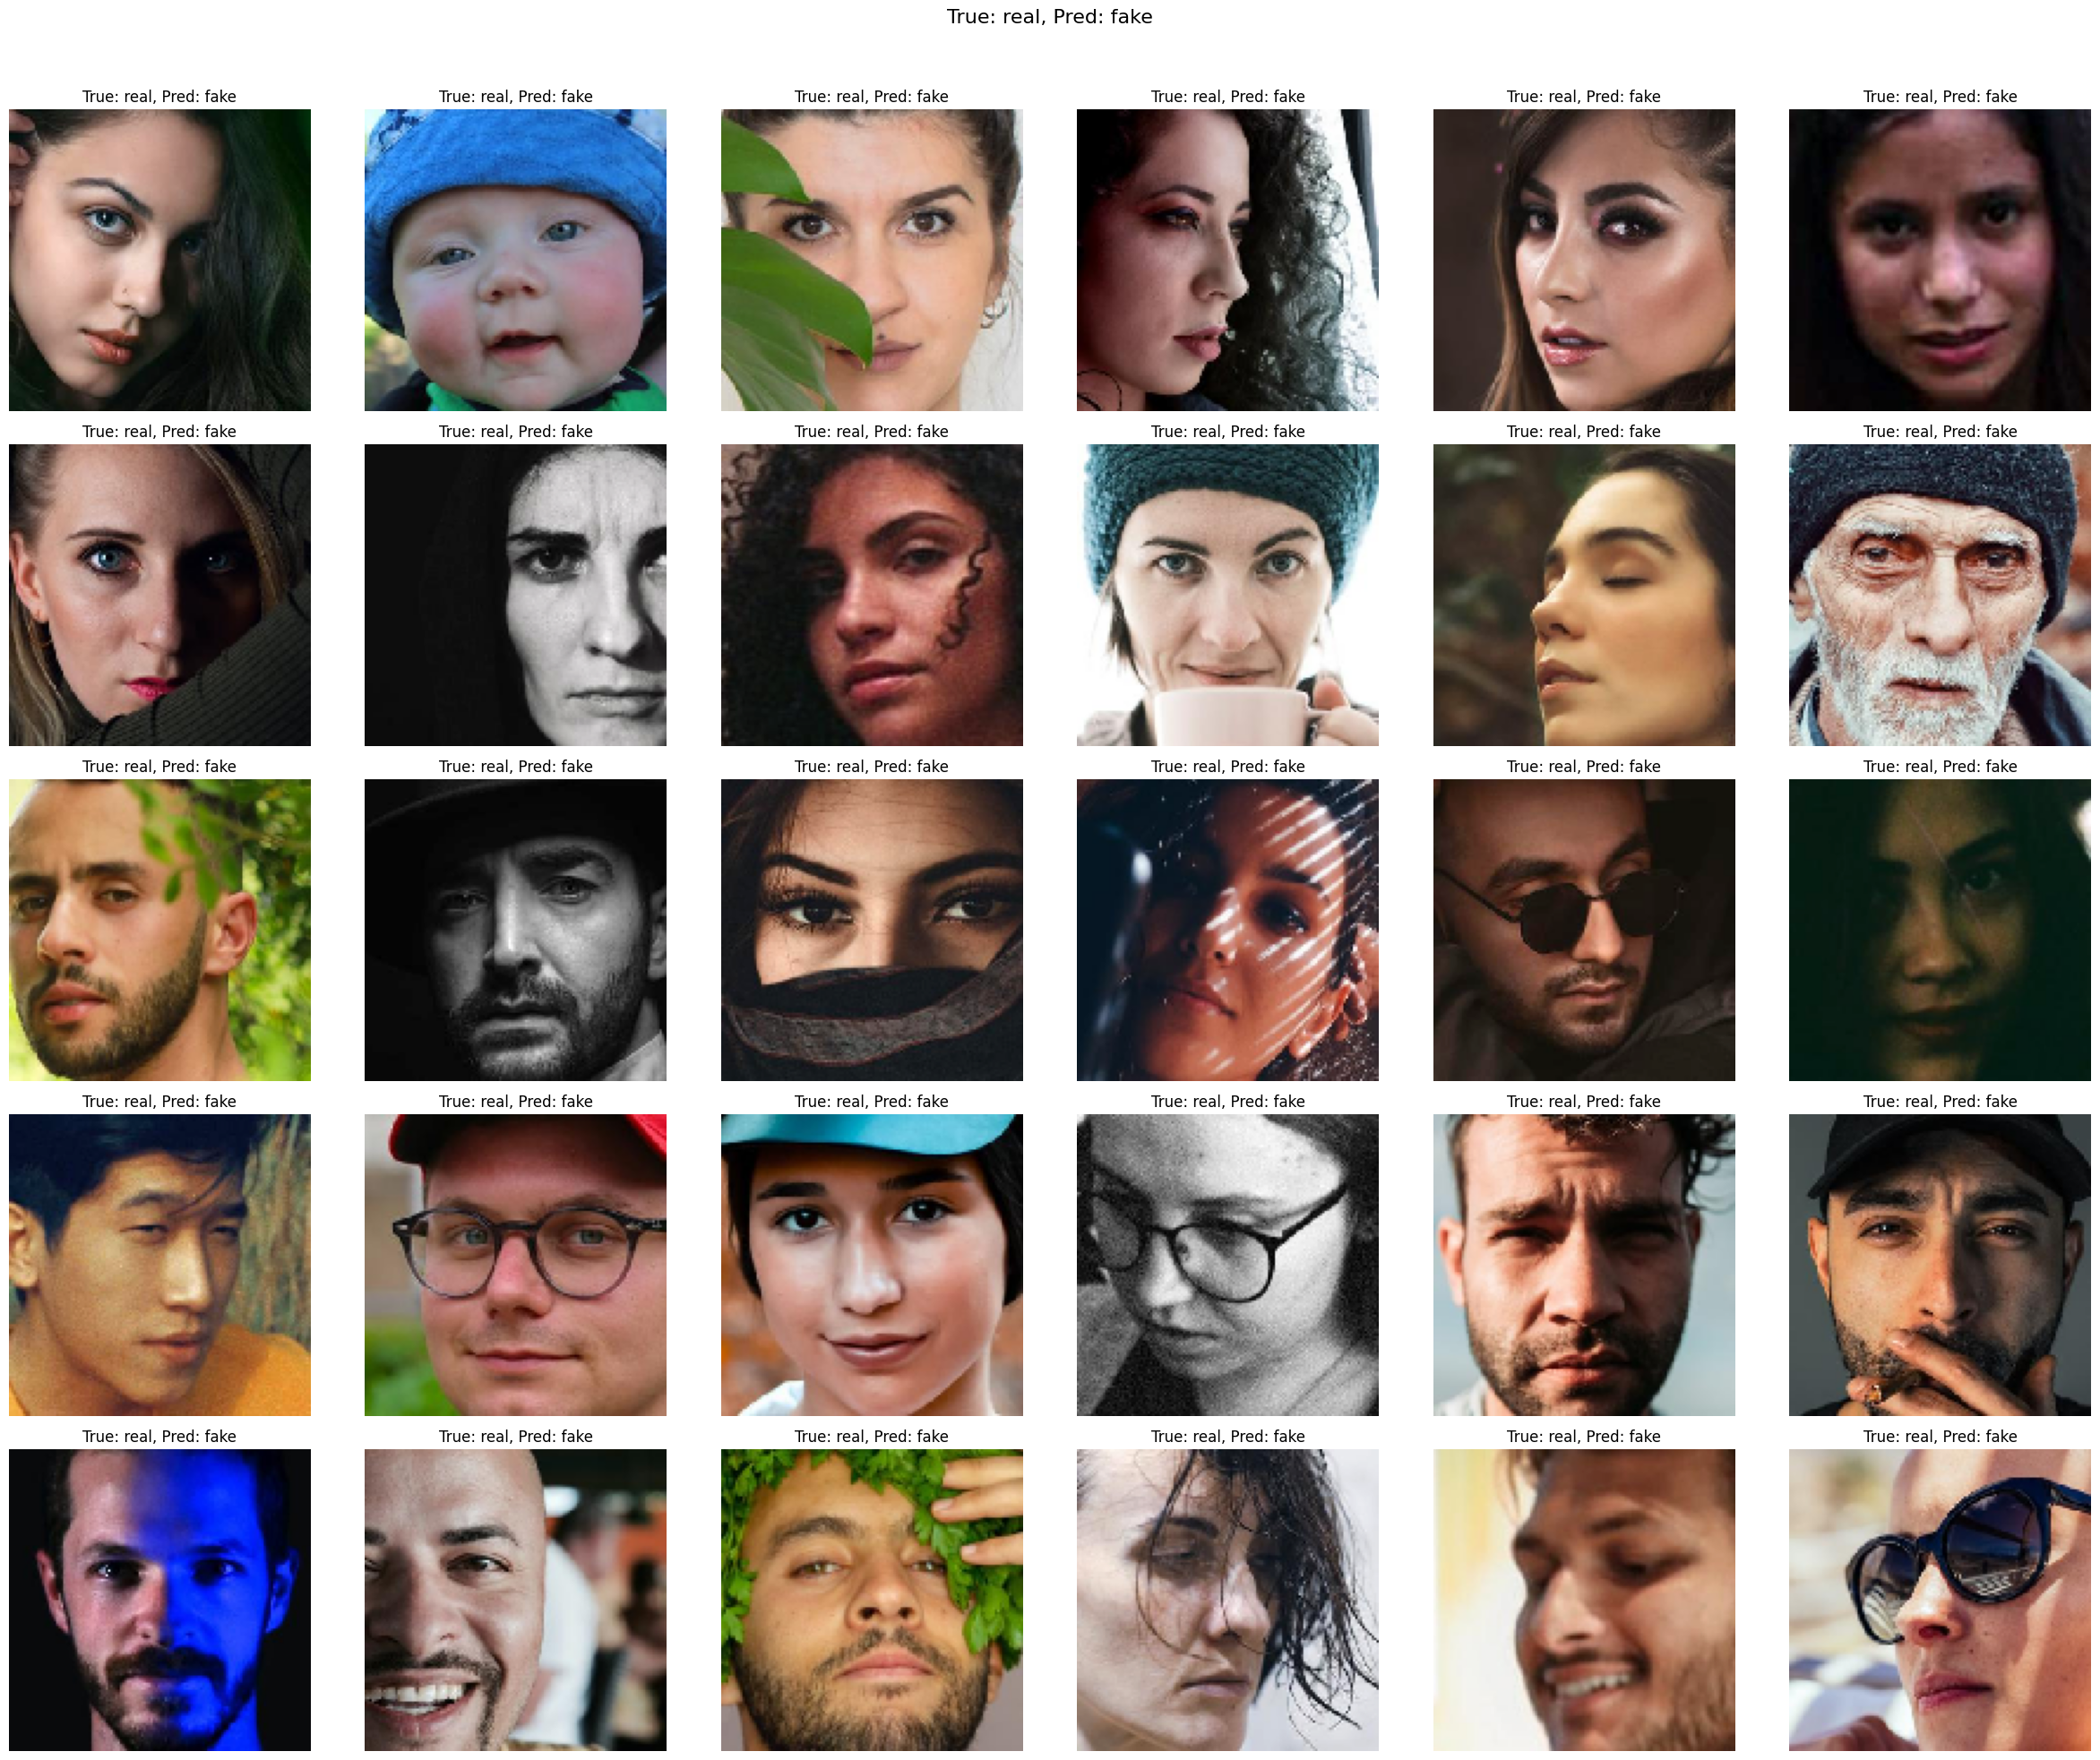

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

# Assume y_true and y_pred_classes are already defined
# y_true = actual labels (as integers)
# y_pred_classes = predicted labels (as integers)

# Get the labels dictionary for reverse lookup
label_dict = {v: k for k, v in labels.items()}

# Get indices of misclassified images
misclassified_indices = np.where(y_true != y_pred_classes)[0]

# Separate misclassified images into the two sets
true_fake_pred_real_indices = [idx for idx in misclassified_indices if y_true[idx] == labels['fake'] and y_pred_classes[idx] == labels['real']]
true_real_pred_fake_indices = [idx for idx in misclassified_indices if y_true[idx] == labels['real'] and y_pred_classes[idx] == labels['fake']]

def plot_misclassified_images(indices, title, num_cols=6):
    num_samples = len(indices)
    num_rows = (num_samples // num_cols) + int(num_samples % num_cols > 0)

    plt.figure(figsize=(num_cols * 4, num_rows * 4))
    plt.suptitle(title, fontsize=16)
    for i, idx in enumerate(indices):
        plt.subplot(num_rows, num_cols, i + 1)
        img = array_to_img(X_test[idx])
        plt.imshow(img)
        plt.title(f'True: {label_dict[y_true[idx]]}, Pred: {label_dict[y_pred_classes[idx]]}')
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to leave space for suptitle
    plt.show()

# Plot misclassified images for True: fake, Pred: real
plot_misclassified_images(true_fake_pred_real_indices, "True: fake, Pred: real", num_cols=6)

# Plot misclassified images for True: real, Pred: fake
plot_misclassified_images(true_real_pred_fake_indices, "True: real, Pred: fake", num_cols=6)


# Output Vizualization

**Training and validation loss**

Text(0.5, 1.0, 'Training and validation loss')

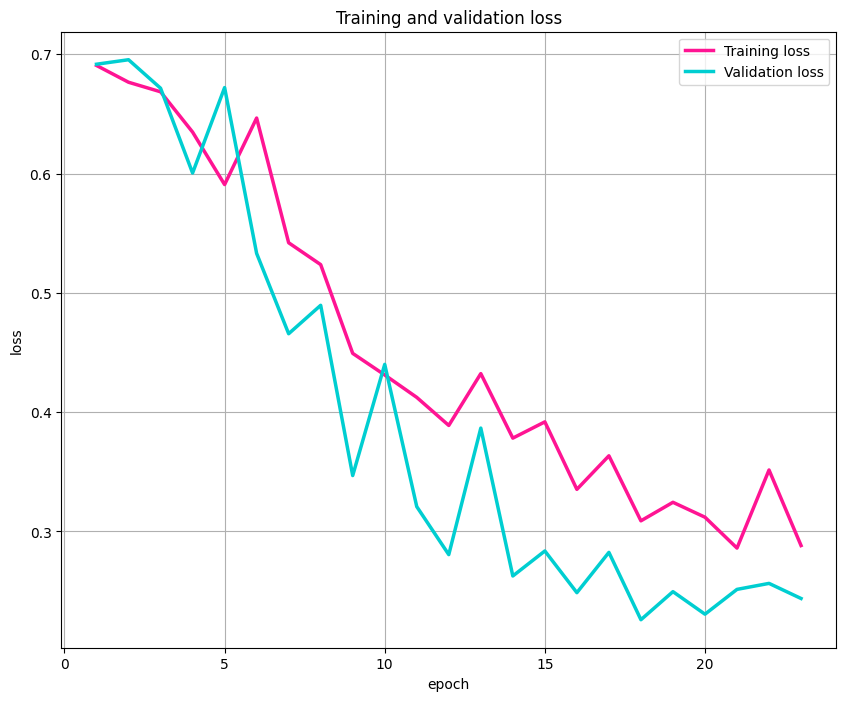

In [36]:
stats_df = pd.DataFrame(history.history)
stats_df['epoch'] = list(range(1, epochs + 1))
plot.figure(figsize=(10, 8))
sb.lineplot(y='loss', x='epoch', data=stats_df, color='deeppink', linewidth=2.5, label="Training loss")
sb.lineplot(y='val_loss', x='epoch', data=stats_df, color='darkturquoise', linewidth=2.5, label="Validation loss")
plot.grid()
plot.legend()
plot.title("Training and validation loss")

**Training and validation accuracy**

Text(0.5, 1.0, 'Training and validation accuracy')

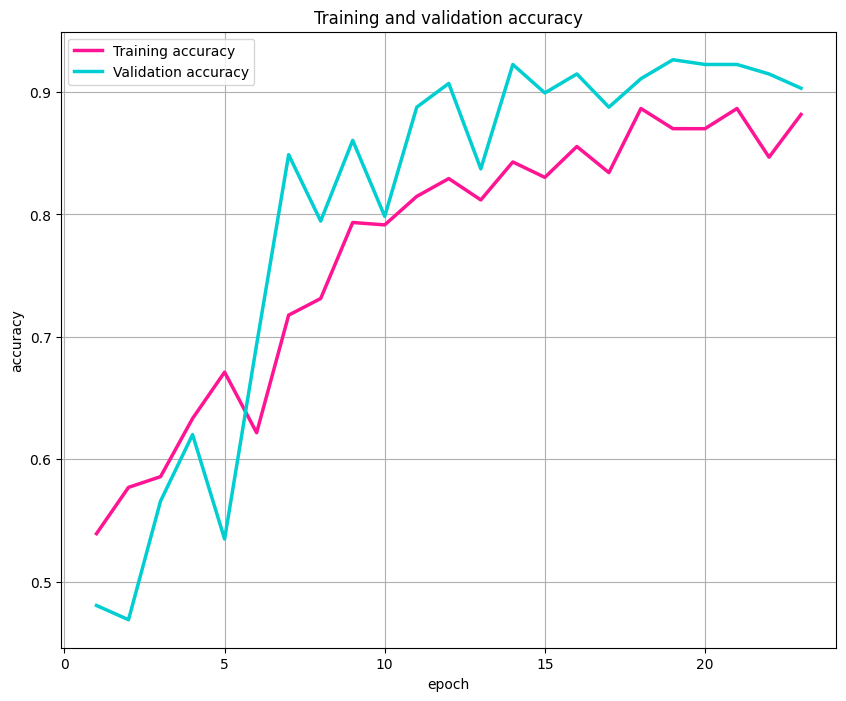

In [37]:
stats_df = pd.DataFrame(history.history)
stats_df['epoch'] = list(range(1, epochs + 1))
plot.figure(figsize=(10, 8))
sb.lineplot(y='accuracy', x='epoch', data=stats_df, color='deeppink', linewidth=2.5, label="Training accuracy")
sb.lineplot(y='val_accuracy', x='epoch', data=stats_df, color='darkturquoise', linewidth=2.5, \
            label="Validation accuracy")
plot.grid()
plot.legend()
plot.title("Training and validation accuracy")

**Class-wise Performance**

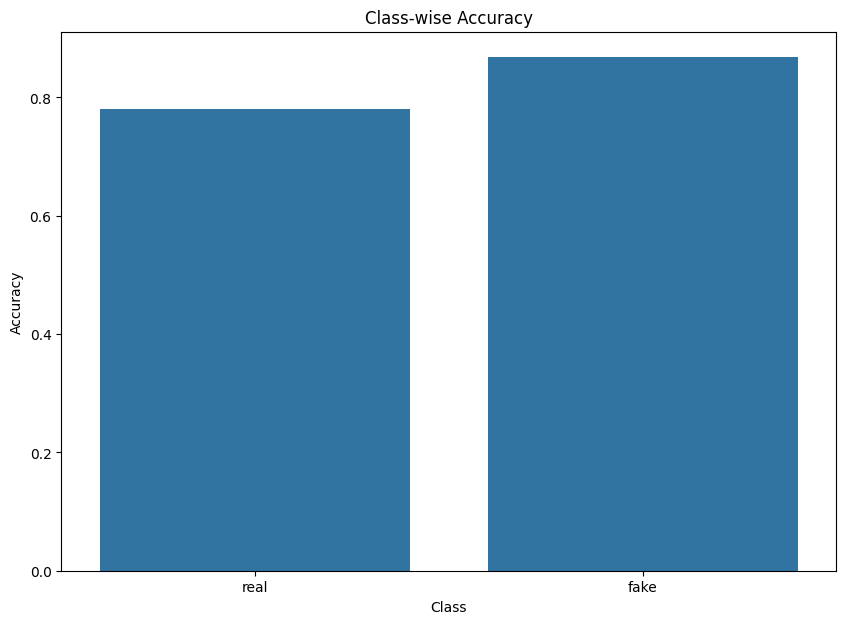

In [38]:
import numpy as np

# Compute class-wise metrics
class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Create a DataFrame for class-wise accuracy
class_metrics = pd.DataFrame({
    'Class': labels.keys(),
    'Accuracy': class_accuracy
})

# Plot class-wise accuracy
plt.figure(figsize=(10, 7))
sns.barplot(x='Class', y='Accuracy', data=class_metrics)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()


**Feature Map**

1/1 [==============================] - 0s 153ms/step


<ipython-input-39-08fab8be5945>:25: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-39-08fab8be5945>:28: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


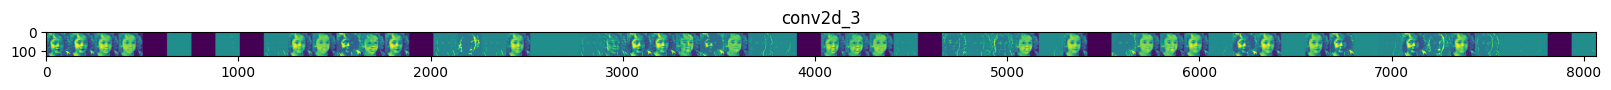

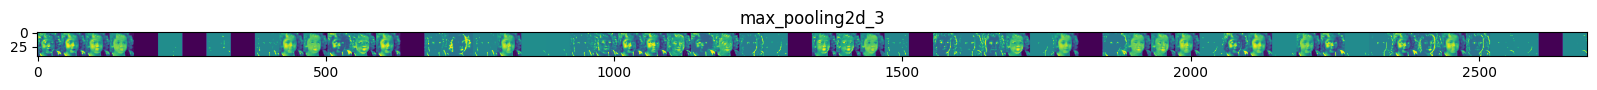

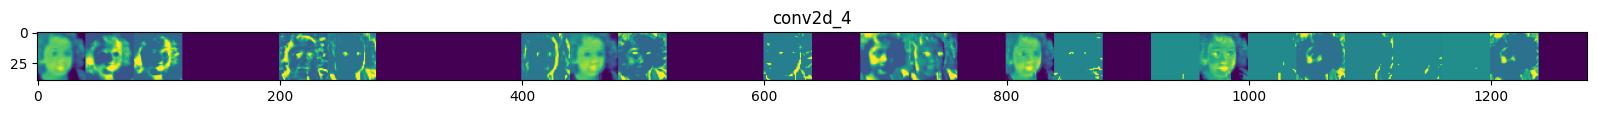

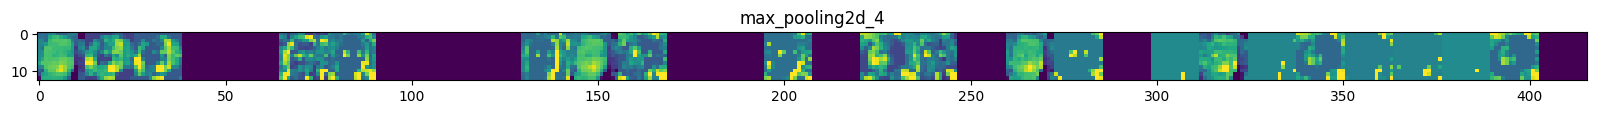

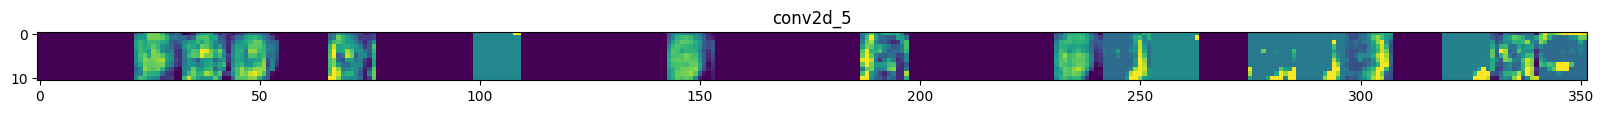

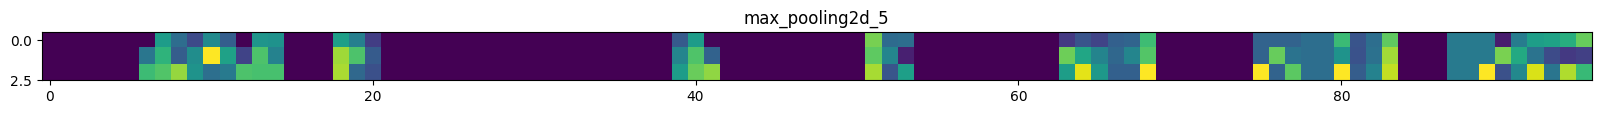

In [39]:
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Choose an image from the test set
img_idx = 0
img = X_test[img_idx]

# Create a model that will output the feature maps
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get feature maps
feature_maps = activation_model.predict(np.expand_dims(img, axis=0))

# Plot the feature maps
for layer_name, feature_map in zip([layer.name for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name], feature_maps):
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))

    for i in range(n_features):
        x = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()
